In [22]:
import torch
import torch.nn as nn

import numpy as np
import cv2
import matplotlib.pyplot as plt
from argparse import Namespace

import wandb
from tqdm import tqdm, trange

import gym
import sneks

torch.__version__

'1.3.1'

In [33]:
def generate_data(env, agent, dataset_size, frame_size, precondition_size):
    total_step = 0
    
    actions = np.zeros((dataset_size, 1), dtype=np.uint8)
    preconditions = np.zeros(
        (dataset_size, precondition_size, 3, *frame_size[::-1]), dtype=np.uint8
    )
    futures = np.zeros((dataset_size, 3, *frame_size[::-1]), dtype=np.uint8)
    
    while True:
        env.reset()
        done = False

        frames_queue = np.zeros(
            (precondition_size + 1, 3, *frame_size[::-1]),
            dtype=np.uint8
        )

        episode_step = 0

        while not done:
            action = agent(env)
            _,  _, done, _ = env.step(action)
            frame = env.render('rgb_array')
            frame = cv2.resize(frame, frame_size)
            frame = np.transpose(frame, (2, 0, 1))
            frame = frame.astype(np.uint8)

            frames_queue = np.roll(frames_queue, shift=-1, axis=0)
            frames_queue[-1] = frame
            
            episode_step += 1
            if episode_step >= precondition_size + 1:
                precondition = frames_queue[:precondition_size]
                future = frames_queue[-1]
                last_action = action

                actions[total_step] = last_action
                preconditions[total_step] = precondition
                futures[total_step] = future

                total_step += 1
                if total_step >= dataset_size:
                    return (actions, preconditions), futures

In [66]:
hparams = Namespace(
    env_name='CubeCrash-v0',
    preconditiion_size=2,
    dataset_size=16,
    frame_size=(32, 32),
)

In [67]:
env = gym.make(hparams.env_name)

In [68]:
(actions, preconditions), futures = generate_data(
    env,
    lambda _: env.action_space.sample(),
    dataset_size=hparams.dataset_size,
    frame_size=hparams.frame_size,
    precondition_size=hparams.preconditiion_size,
)
actions.shape, preconditions.shape, futures.shape

((16, 1), (16, 2, 3, 32, 32), (16, 3, 32, 32))

1

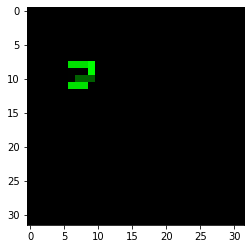

In [69]:
idx = 4
t1 = np.transpose(preconditions[idx, 1], (1, 2, 0))
t2 = np.transpose(futures[idx], (1, 2, 0))
plt.imshow(abs(t1 - t2))
actions[idx, 0]

In [70]:
def nn_dense(i, o, a=None):
    l = nn.Linear(i, o)
    return l if a is None else nn.Sequential(l, a)

def nn_conv()

def nn_lambda(lam):
    class Lambda(nn.Module):
        def forward(self, *args, **kwargs):
            return lam(*args, **kwargs)
        
    return Lambda()

In [ ]:
class Model(nn.Module):
    def __init__(self):
        self.action_encoder = nn.Sequential(
            nn_dense(1 , 32, nn.LeakyReLU(0.2)),
            nn_dense(32, 32, nn.LeakyReLU(0.2)),
            nn_dense(32, 64, nn.LeakyReLU(0.2)),
            nn_lambda(lambda x: x.reshape(-1, 8, 8))
            nn_lambda(lambda x: x.reshape(-1, 8, 8))
        )